In [1]:
import numpy as np
import sys
from matplotlib import pyplot as plt

In [2]:
data = np.load('/arc/projects/chime_frb/mseth/cyg_A/frb_CYG_A_2025-07-03_beam_1105.npz', allow_pickle=True) 

spectra = data['spectra']
median_timeseries = data['median_timeseries']
median_ts = np.mean(spectra, axis=0)


peak_ind = np.argmax(median_ts)
spectra_at_peak = spectra[:, peak_ind]
spectra_at_peak[spectra_at_peak==0] = np.nan  # Replace zeros with NaN for better visualization


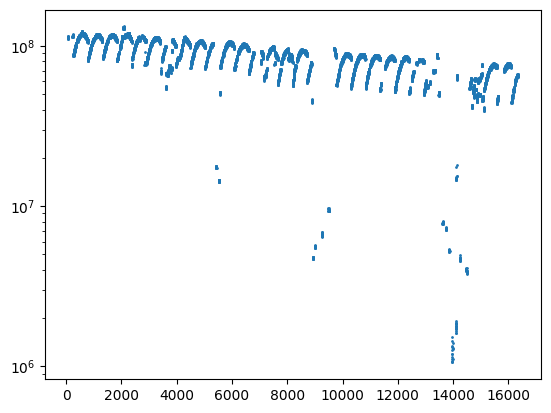

In [4]:
# Look at spectra from data
plt.figure()
plt.scatter(np.arange(len(spectra_at_peak)), spectra_at_peak, label='Spectra at Peak',s=1)
plt.yscale('log')


In [5]:
### Different ###
sys.path.insert(0, '/arc/home/mseth/beam-model')
#################


from beam_model import composite 
from beam_model import utils as u

### Different ### 
from beam_model.bm_data.get_data import main
from beam_model import config
#################

cbm = composite.CompositeBeamModel()
CygA_RA = 299.8681525
CygA_Dec = 40.7339156

In [7]:
from datetime import datetime
from datetime import timedelta


### Different ###
sys.path.append("/arc/home/mseth/.local/lib/python3.11/site-packages")
import astrodendro
sys.path.insert(0, '/arc/home/mseth/frb-calibration-master')
#################

from frb_calibration import intensity_calibration_helpers as ich
time, beam = ich.get_calibrator_transit(CygA_RA, CygA_Dec, "20200217")

#convert time to datetime
start_date = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f UTC+0000')- timedelta(minutes=10)
date_time_arr = [start_date + timedelta(seconds=i) for i in range(1200)]
x_arr = []
y_arr = []
sensitivity_arr = []
for date_time in date_time_arr:
    x, y = cbm.get_position_from_equatorial(CygA_RA, CygA_Dec, date_time)
    x_arr.append(x)
    y_arr.append(y)

x_arr = np.array(x_arr)
y_arr = np.array(y_arr)

In [8]:
freq_low = 400.390625 # MHz
freq_high = 800 # MHz
#there's 16384 channels in the band
freqs = np.linspace(freq_low, freq_high, 16384)/1000 # convert to GHz


In [9]:
sensitivity = cbm.get_sensitivity([1105], np.array([x_arr, y_arr]).T, freqs*1000).squeeze()
#average over the spectra axis
mean_sensitivity = np.nanmean(sensitivity, axis=1)
#find the peak of the mean sensitivity
peak_sensitivity_ind = np.argmax(mean_sensitivity)
#get response at the peak
sensitivity_at_peak = sensitivity[peak_sensitivity_ind, :]
#divide the spectra at peak by the sensitivity at peak

spectra_corrected = spectra_at_peak / sensitivity_at_peak

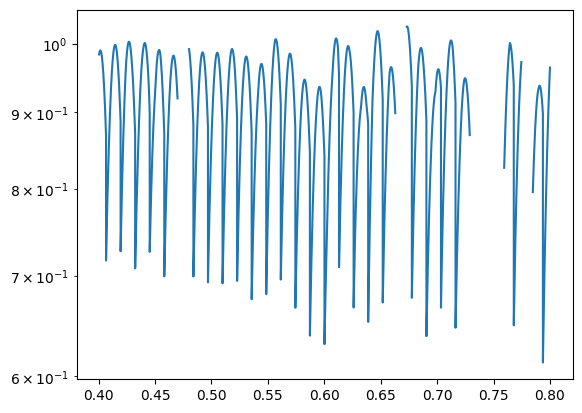

In [16]:
# Look at spectra of beam sensitivity
plt.figure()
plt.plot(freqs, sensitivity_at_peak, label='Sensitivity at Peak')
plt.yscale('log')

In [12]:
def bf_to_jy(bf_spectrum, f_good):
    factor = (np.square(1024) * 128) / (np.square(4) * 0.806745 * 400)
    result = bf_spectrum / ( factor * np.square(f_good) ) 
    return result

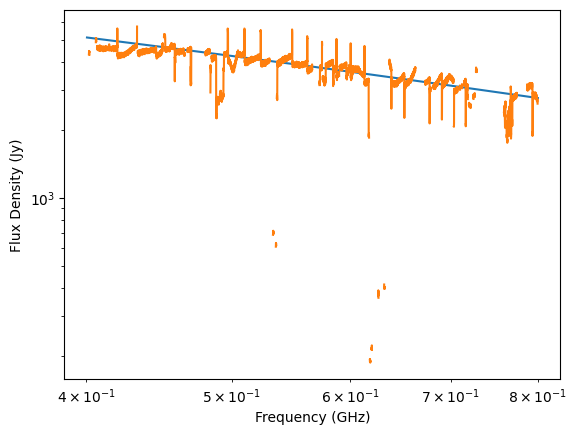

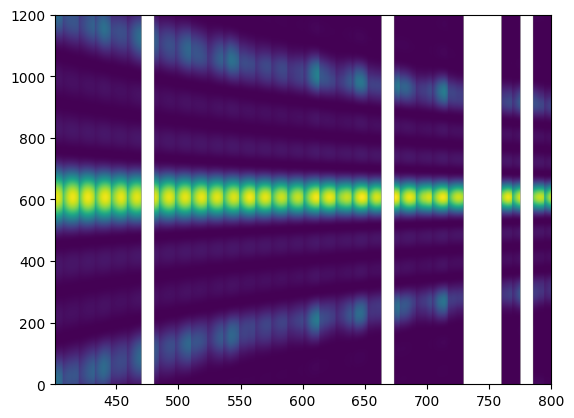

In [14]:
#correct to jansky units
spectra_jy = bf_to_jy(spectra_corrected, 1)

#get the spectrum of cyga
a0 = 3.34598
a1 = -1.0022
a2 = -0.225
a3 = 0.023
a4= 0.043
log_flux = a0 + a1 * np.log10(freqs) + a2 * np.log10(freqs)**2 + a3 * np.log10(freqs)**3 + a4 * np.log10(freqs)**4
#correct the spectra at peak by the beam model

plt.figure()
plt.plot(freqs, 10**log_flux, label='CygA Spectrum')
plt.plot(freqs, spectra_jy, label='CygA Spectrum at Peak')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux Density (Jy)')
plt.show()
plt.imshow(sensitivity, aspect='auto', extent=(freq_low, freq_high, 0, 1200), origin='lower')
plt.show()